In [1]:
import pandas as pd
from scipy import stats 
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import numpy as np
import joblib
import os
import tensorflow as tf
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

## UDFs

In [318]:
def predictions(mae_lstm, mae_xgboost, prediction_xgb, prediction_lstm):
    
    prediction = ((prediction_xgb*mae_xgboost)+(prediction_lstm*mae_lstm))/(mae_lstm+mae_xgboost)
    return prediction

In [2]:
def windowing_lstm(train, val, window, prediction_scope):
    
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train[i:i+WINDOW, :-1]), np.array(train[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(val[i:i+WINDOW, :-1]), np.array(val[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        
    
    return X_train, y_train, X_test, y_test

In [3]:
def plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE):
    
    """This function returns a graph where:
        - Validation Set
        - Test Set
        - Future Prediction
        - Upper Bound
        - Lower Bound
    """
    
    ploting_pred = [y_test[-1], pred_test]
    ploting_test = [y_val[-1]]+list(y_test)

    time = (len(y_val)-1)+(len(ploting_test)-1)+(len(ploting_pred)-1)

    test_time_init = time-(len(ploting_test)-1)-(len(ploting_pred)-1)
    test_time_end = time-(len(ploting_pred)-1)+1

    pred_time_init = time-(len(ploting_pred)-1)
    pred_time_end = time+1

    x_ticks = list(stock_prices.index[-time:])+[stock_prices.index[-1]+timedelta(PREDICTION_SCOPE+1)]

    values_for_bounds = list(y_val)+list(y_test)+list(pred_test)
    upper_band = values_for_bounds+mae
    lower_band = values_for_bounds-mae
    
    print(f"For used windowed data: {WINDOW}")
    print(f"Prediction scope for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days")
    print(f"The predicted price is {str(round(ploting_pred[-1][0],2))}$")
    print(f"With a spread of MAE is {round(mae,2)}")
    print()
    
    plt.figure(figsize=(16, 8))

    plt.plot(list(range(test_time_init, test_time_end)),ploting_test, marker="$m$", color="orange")
    plt.plot(list(range(pred_time_init, pred_time_end)),ploting_pred,marker="$m$", color="red")
    plt.plot(y_val, marker="$m$")

    plt.plot(upper_band, color="grey", alpha=.3)
    plt.plot(lower_band, color="grey", alpha=.3)

    plt.fill_between(list(range(0, time+1)),upper_band, lower_band, color="grey", alpha=.1)

    plt.xticks(list(range(0-1, time)), x_ticks, rotation=45)
    plt.text(time-0.5, ploting_pred[-1]+2, str(round(ploting_pred[-1][0],2))+"$", size=11, color='red')
    plt.title(f"Target price for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days, with used past data of {WINDOW} days and a MAE of {round(mae,2)}", size=15)
    plt.legend(["Testing Set (input for Prediction)", "Prediction", "Validation"])
    plt.show()
    
    print()
    print("-----------------------------------------------------------------------------")
    print()

In [4]:
def sp500_log_rets(tickers):
    
    """Returns the logarithmic returns from the SP500"""
    
    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]
    log_rets = {}
    for index, ticker in enumerate(tickers):
        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))
    return log_rets

In [5]:
def annualized_rets(r):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(255/n_periods)-1

In [6]:
def windowing(train, val, WINDOW, PREDICTION_SCOPE):
    
    """Divides the inserted data into a list of lists. Where the shape of the data becomes and additional axe, which is time
    Input:
        - Train Set
        - Validation Set
        - WINDOW: the desired window
        - PREDICTION_SCOPE: The period in the future you want to analyze
    """
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train[i:i+WINDOW, :-1]), np.array(train[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(val[i:i+WINDOW, :-1]), np.array(val[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        
    
    return X_train, y_train, X_test, y_test

In [7]:
def feature_engineering(data, SPY, predictions=np.array([None])):
    
    """
    The function applies future engineering to the data in order to get more information out of the inserted data.
    """
    if predictions.any() ==  True:
        data = yf.download("AAPL", start="2001-11-30")
        SPY = yf.download("SPY", start="2001-11-30")["Close"]
        data = features(data, SPY)
        print(data.shape)
        data["Predictions"] = predictions
        data["Close"] = data["Close_y"]
        data.drop("Close_y",1,  inplace=True)
        data.dropna(0, inplace=True)
    else:
        print("No model yet")
        data = features(data, SPY)
    return data

def features(data, SPY):
    
    for i in [2, 3, 4, 5, 6, 7]:
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).mean()
        data[f"Volume{i}"] = data["Volume"].rolling(i).mean()

        data[f"Low_std{i}"] = data["Low"].rolling(i).std()
        data[f"High_std{i}"] = data["High"].rolling(i).std()
        data[f"Adj_CLose{i}"] = data["Adj Close"].rolling(i).std()

        data[f"Close{i}"] = data["Close"].shift(i)

        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).max()
        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).min()

        data[f"Adj_Close{i}"] = data["Adj Close"].rolling(i).quantile(1)
    
    
    #FEATURE ENGINEERING
    data["SPY"] = SPY
    data["Day"] = data.index.day
    data["Month"] = data.index.day
    data["Year"] = data.index.day
    data["day_year"] = data.index.day_of_year
    data["Weekday"] = data.index.weekday
    data["Upper_Shape"] = data["High"]-np.maximum(data["Open"], data["Close"])
    data["Lower_Shape"] = np.minimum(data["Open"], data["Close"])-data["Low"]
    data["Close_y"] = data["Close"]
    data.drop("Close",1,  inplace=True)
    data.dropna(0, inplace=True)
    return data

In [8]:
def train_test_split(data, WINDOW):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    train = stock_prices.iloc[:-WINDOW]
    test = stock_prices.iloc[-WINDOW:]
    
    return train, test

In [73]:
def train_validation_split(train, percentage):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    train_set = train.iloc[:int(len(train)*percentage)]
    validation_set = train.iloc[int(len(train)*percentage):]
    
    
    return train_set, validation_set

In [10]:
def log_returns(train, percentage):
    """
    Returns log returns
    """
    
    train_logrets = np.log(train.iloc[:int(len(train)*percentage)]["Close_y"]/train.iloc[:int(len(train)*percentage)]["Close_y"].shift(1))
    val_logrets = np.log(train.iloc[int(len(train)*percentage):]["Close_y"]/train.iloc[int(len(train)*percentage):]["Close_y"].shift(1))
    return train_logrets, val_logrets

In [240]:
def inverse_transformation(X, y, y_hat):
    
    """
    This function serves to inverse the rescaled data. 
    There are two ways in which this can happen:
        - There could be the conversion for the validation data to see it on the plotting.
        - There could be the conversion for the testing data, to see it plotted.
    """
    
    if X.shape[1]>1:
        new_X = []

        for i in range(len(X)):
            new_X.append(X[i][0])
            
        new_X = np.array(new_X)
        y = np.expand_dims(y, 1)
        
        new_X = pd.DataFrame(new_X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)

        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        
    else:
        
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        
        new_X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        y_hat = pd.DataFrame(y_hat)
        y_hat = pd.concat((y, y_hat))
        y_hat.index = range(len(y_hat))
        
        real_val = np.array(pd.concat((new_X, y), 1))
        pred_val = np.array(pd.concat((new_X, y_hat), 1))
        
        pred_val = pd.DataFrame(scaler.inverse_transform(pred_val))
        real_val = pd.DataFrame(scaler.inverse_transform(real_val))
        
    return real_val, pred_val

In [11]:
def xgb_model(X_train, y_train, X_val, y_val, plotting=False):
     
    xgb_model = xgb.XGBRegressor(gamma=1, n_estimators=200)
    xgb_model.fit(X_train,y_train)
    
    
    pred_val = xgb_model.predict(X_val)
    mae = mean_absolute_error(y_val, pred_val)
    
    
    
    if plotting == True:
        
        plt.figure(figsize=(15, 6))
        
        sns.set_theme(style="white")
        sns.lineplot(range(len(y_val)), y_val, color="grey", alpha=.4)
        sns.lineplot(range(len(y_val)),pred_val, color="red")

        plt.xlabel("Time")
        plt.ylabel("AAPL stock price")
        plt.title(f"The MAE for this period is: {round(mae, 3)}")
    
    return  mae, xgb_model

In [236]:
def lstm_model(X_train, y_train, X_val, y_val, EPOCH, plotting=False):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get("val_mae")<.034):
                print("\n Accuracy % so cancelling training")
                self.model.stop_training=True

    callbacks = myCallback()
    
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)


    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.228 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.228, momentum =.85)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics="mae")
    history = model.fit(X_train, y_train,batch_size=15, epochs=EPOCH,callbacks=[callbacks],  validation_data=[X_val, y_val], verbose=1)
    
    if plotting == True:
        plt.figure(figsize=(18, 6))

        lrs = 1e-5 * (10 ** (np.arange(len(history.history["loss"])) / 20))
        plt.semilogx(lrs, history.history["loss"])
        plt.xticks(size=14)
        plt.show()
    
    return model

## Data Overview

In [13]:
stock_prices = yf.download("AAPL", start="2001-11-30")
SPY = yf.download("SPY", start="2001-11-30")["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
rets = np.log(stock_prices["Close"]/stock_prices["Close"].shift(1))

In [15]:
stock_prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5076.000000,5076.000000,5076.000000,5076.000000,5076.000000,5.076000e+03
mean,27.030850,27.317815,26.744489,27.041181,25.866270,4.270450e+08
std,36.380515,36.792514,35.979819,36.399114,36.374911,3.867511e+08
min,0.231964,0.235536,0.227143,0.234286,0.200869,2.653234e+07
25%,3.027946,3.069554,2.988661,3.026697,2.594984,1.463086e+08
50%,14.445892,14.601072,14.297322,14.463393,12.443431,3.026450e+08
75%,32.523127,32.737500,32.313125,32.534374,29.695389,5.829845e+08
max,182.630005,182.940002,179.119995,182.009995,182.009995,3.372970e+09


In [16]:
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "SPY"]

In [17]:
log_rets = sp500_log_rets(tickers)

[*********************100%***********************]  5 of 5 completed


In [18]:
#Annual rets for the selected tickers
ann_rets = {}
for ticker in log_rets.keys():
    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"
ann_rets

{'AAPL': '27.29%',
 'MSFT': '31.17%',
 'TSLA': '45.67%',
 'AMZN': '27.05%',
 'SPY': '12.54%'}

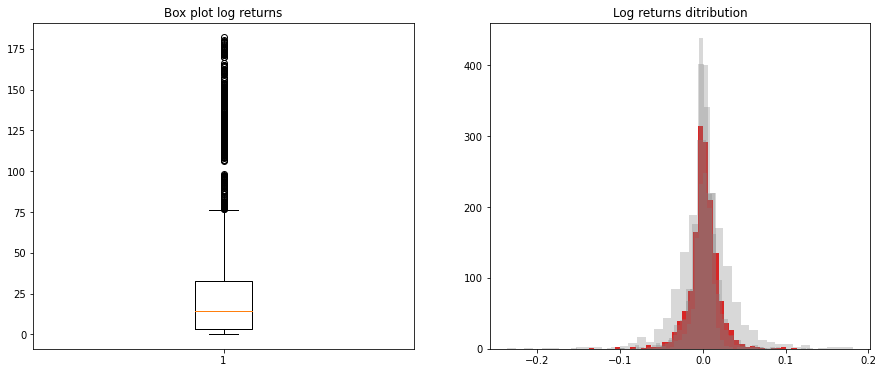

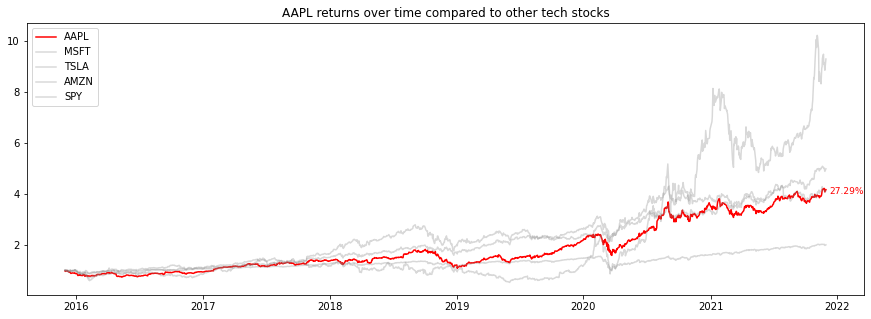

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax[1].hist(log_rets[i], bins=40, color = "red")
        ax[0].boxplot(stock_prices["Close"])
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")
    else:
        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")


fig,ax = plt.subplots(figsize=(15,5))
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax.plot((1+log_rets[i]).cumprod(), color="red")

    else:
        ax.plot((1+log_rets[i]).cumprod(), color="grey", alpha=.3)

ax.legend(tickers)
ax.set_title("AAPL returns over time compared to other tech stocks")
ax.text(18970, 4, ann_rets["AAPL"], size=9, color='red')

plt.show()

# XGBoost

XGBoost, is one of the most highly used supervised ML algorithms nowadays.

The algorithm uses a more optimized way to implement a tree based algorithm.

The methodology followed by this algorithm is the following. XGBoost uses a Greedy algorithm for the building of its tree, meaning it uses a simple intuitive way to optimze the algorithm. This is done by making a prediction (which acts as a threshols), before starting to evaluate the rest of the observations, which then turn into other thresholds, and so on.

This methods enables it to manage huge amount of data very quickly.

In the case of regression, it basically build up a Regression Tree through the residuals of each data point to the initial prediction. Then we split the data into portions and compare one to another and see which one is better at splitting the residuals into clusters of similar values.

For more insights into how this algorithm works, check out this video from [StatQuest](https://www.youtube.com/watch?v=OtD8wVaFm6E&t=649s)
stock_prices = yf.download("AAPL", start="2001-11-30")

## Feature Engineering

We will firt make the analysis forecasting 1 period ahead

In [20]:
PERCENTAGE = .995

WINDOW = 2
PREDICTION_SCOPE = 0

In [21]:
stock_prices = feature_engineering(stock_prices, SPY)

No model yet


In [22]:
train, test = train_test_split(stock_prices, WINDOW)

In [23]:
print(train.shape)
print(test.shape)

(5067, 50)
(2, 50)


Here are some functions that pretend to ease us the work while applying the same algorithm on different period forecasts

In [24]:
train_set, validation_set = train_validation_split(train, PERCENTAGE)

X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

In [25]:
#Reshaping the Data

X_train = np.array(X_train)
y_train = np.array(y_train)


X_val = np.array(X_val)
y_val = np.array(y_val)



X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

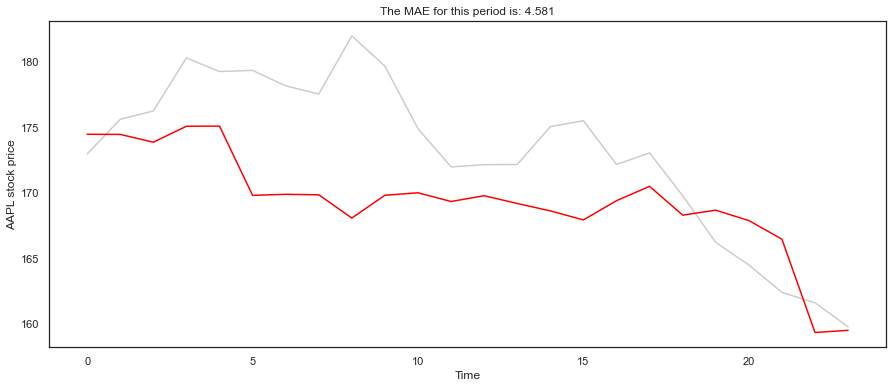

In [26]:
mae, xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

## Add the predictions (if needed)

In [27]:
#try:
    #y_hat_train = np.expand_dims(xgb_model.predict(X_train), 1)
    #array = np.empty((stock_prices.shape[0]-y_hat_train.shape[0], 1))
    #array[:] = np.nan
    #predictions = np.concatenate((array, y_hat_train))
#except NameError:
    #print("No Model")
    
    
#new_stock_prices = feature_engineering(stock_prices, SPY, predictions=predictions)


#train, test = train_test_split(new_stock_prices, WINDOW)

#train_set, validation_set = train_validation_split(train, PERCENTAGE)
#X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

#Reshaping the data
#X_train = np.array(X_train)
#y_train = np.array(y_train)

#X_val = np.array(X_val)
#y_val = np.array(y_val)

#X_train = X_train.reshape(X_train.shape[0], -1)
#X_val = X_val.reshape(X_val.shape[0], -1)


#new_mae, new_xgb_model = xgb_model(X_train, y_train, X_val, y_val, plotting=True)

#print(new_mae)

## Evaluation on the Test Set

In [28]:
X_test = np.array(test.iloc[:, :-1])
y_test = np.array(test.iloc[:, -1])

print(X_test.shape)

(2, 49)


In [29]:
X_test = X_test.reshape(1, -1)

print(X_test.shape)

(1, 98)


In [326]:
#Apply the xgboost model on the Test Data

pred_test_xgb = xgb_model.predict(X_test)

For used windowed data: 30
Prediction scope for date 2022-01-28 00:00:00 / 1 days
The predicted price is 155.06$
With a spread of MAE is 7.6



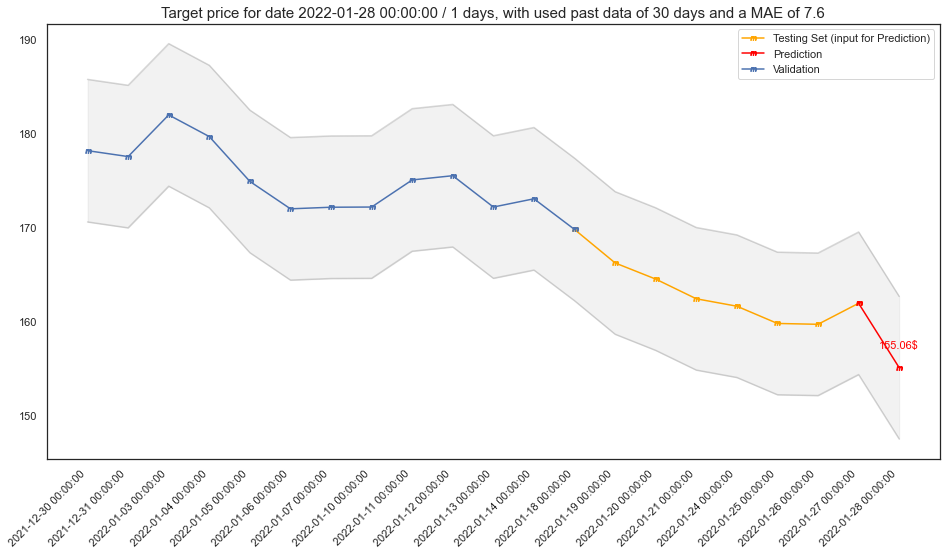


-----------------------------------------------------------------------------



In [327]:
plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE)

## Saving the XGBoost parameters

In [32]:
#joblib.dump(xgb_model, "XGBoost.pkl")

## MULTIPLE EVALUATIONS

In [33]:
plots = {}


for window in [1, 2, 3, 4, 5, 6, 7]:
    
    for pred_scope in [0 ,1, 2, 4, 5, 6]:

        WINDOW = window
        PREDICTION_SCOPE = pred_scope

        train = stock_prices.iloc[:int(len(stock_prices))-WINDOW]
        test = stock_prices.iloc[-WINDOW:]
        
        train_set, validation_set = train_validation_split(train, PERCENTAGE)

        X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)
        #The shaded area is used if we wanted to validate the model. I am using the last data in order to make a prediction

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        X_val = np.array(X_val)
        y_val = np.array(y_val)

        X_test = np.array(test.iloc[:, :-1])
        y_test = np.array(test.iloc[:, -1])

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)
        X_test = X_test.reshape(1, -1)

        xgb_model = xgb.XGBRegressor(gamma=1)
        xgb_model.fit(X_train, y_train)

        pred_val = xgb_model.predict(X_val)

        mae = mean_absolute_error(y_val, pred_val)

        pred_test = xgb_model.predict(X_test)
        plotii= [y_test[-1], pred_test]

        plots[str(window)+str(pred_scope)] = [y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE]
    

In [34]:
print()
print(plots["10"])
print("-----------------------------------------------------------------------------------------------------------------")
print(plots["11"])


[array([172.99000549, 175.63999939, 176.27999878, 180.33000183,
       179.28999329, 179.38000488, 178.19999695, 177.57000732,
       182.00999451, 179.69999695, 174.91999817, 172.        ,
       172.16999817, 172.19000244, 175.08000183, 175.52999878,
       172.19000244, 173.07000732, 169.80000305, 166.22999573,
       164.50999451, 162.41000366, 161.61999512, 159.77999878,
       159.69000244]), array([161.92999268]), array([159.14516], dtype=float32), 3.24302001953125, 1, 0]
-----------------------------------------------------------------------------------------------------------------
[array([175.63999939, 176.27999878, 180.33000183, 179.28999329,
       179.38000488, 178.19999695, 177.57000732, 182.00999451,
       179.69999695, 174.91999817, 172.        , 172.16999817,
       172.19000244, 175.08000183, 175.52999878, 172.19000244,
       173.07000732, 169.80000305, 166.22999573, 164.50999451,
       162.41000366, 161.61999512, 159.77999878, 159.69000244]), array([161.92999268]

For used windowed data: 1
Prediction scope for date 2022-01-28 00:00:00 / 1 days
The predicted price is 159.15$
With a spread of MAE is 3.24



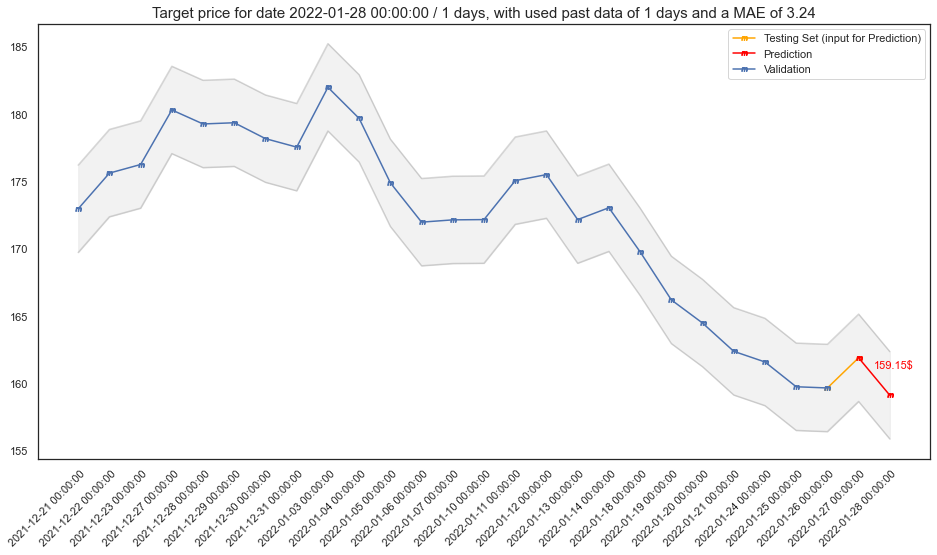


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-29 00:00:00 / 2 days
The predicted price is 160.67$
With a spread of MAE is 4.42



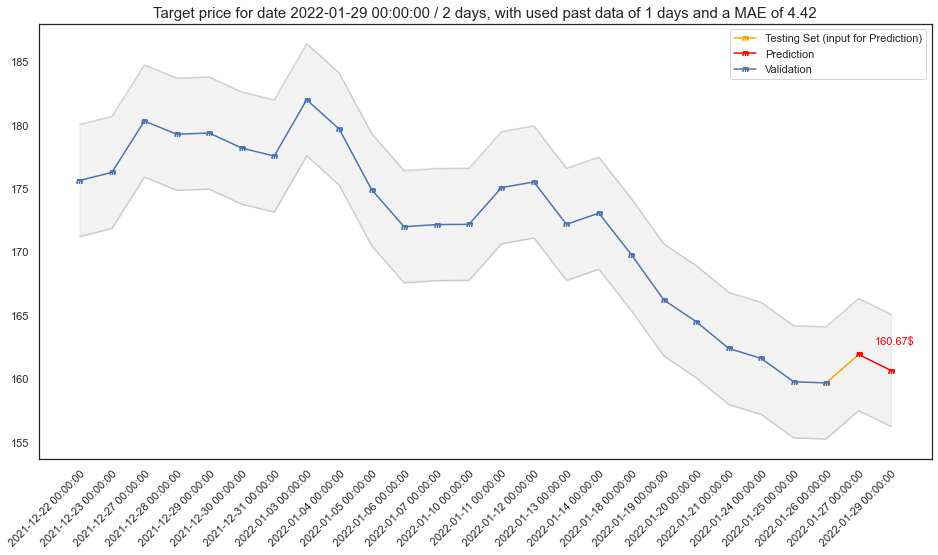


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-30 00:00:00 / 3 days
The predicted price is 160.21$
With a spread of MAE is 7.19



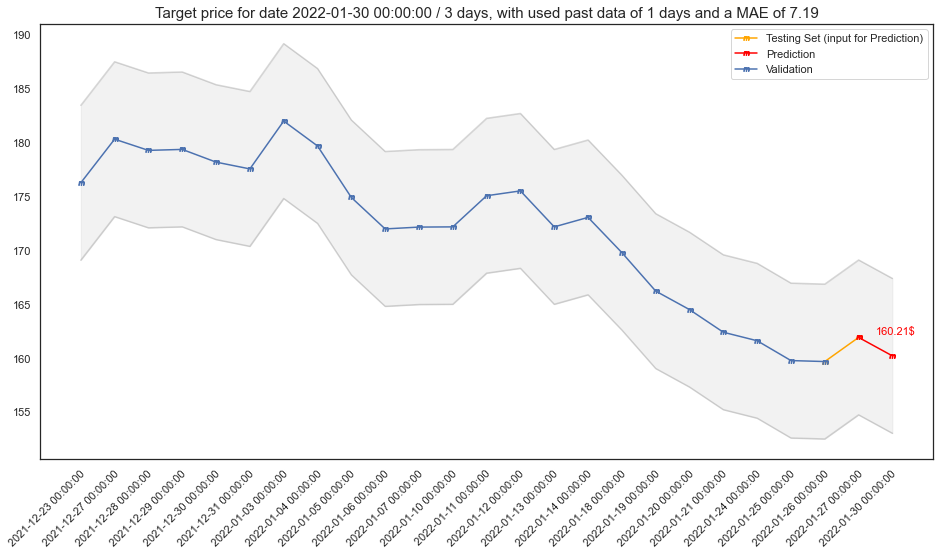


-----------------------------------------------------------------------------



In [35]:
for key in list(plots.keys())[:3]:
    plotting(plots[key][0], plots[key][1], plots[key][2], plots[key][3], plots[key][4], plots[key][5])

# LSTM



In [287]:
PERCENTAGE = .9899

EPOCH = 50
WINDOW_LSTM = 30
PREDICTION_SCOPE = 0

In [288]:
train_lstm, test_lstm = train_test_split(stock_prices, WINDOW_LSTM)

In [289]:
train_split_lstm, validation_split_lstm = train_validation_split(train_lstm, PERCENTAGE)

## Rescaling to train the LSTM

In [290]:
scaler = MinMaxScaler()
scaler.fit(train_split_lstm)

MinMaxScaler()

In [291]:
print(train_split_lstm.shape)
print(validation_split_lstm.shape)

(4988, 50)
(51, 50)


In [292]:
train_split_lstm = np.array(train_split_lstm)
validation_split_lstm = np.array(validation_split_lstm)

In [293]:
train_scale_lstm = scaler.transform(train_split_lstm)
val_scale_lstm = scaler.transform(validation_split_lstm)
test_scale_lstm = scaler.transform(test_lstm)

In [294]:
print(train_scale_lstm.shape)
print(val_scale_lstm.shape)
print(test_scale_lstm.shape)

(4988, 50)
(51, 50)
(30, 50)


In [295]:
X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm = windowing(train_scale_lstm, val_scale_lstm, WINDOW, PREDICTION_SCOPE)

In [296]:
X_train_lstm = np.array(X_train_lstm)
y_train_lstm = np.array(y_train_lstm)

X_val_lstm = np.array(X_val_lstm)
y_val_lstm = np.array(y_val_lstm)

X_test_lstm = np.array(test_scale_lstm[:, :-1])
y_test_lstm = np.array(test_scale_lstm[:, -1])

In [297]:
print(X_train_lstm.shape)
print(X_val_lstm.shape)
print(X_test_lstm.shape)

(4958, 30, 49)
(21, 30, 49)
(30, 49)


Epoch 1/50
331/331 [==============================] - 26s 57ms/step - loss: 6.2265e-04 - mae: 0.0182 - val_loss: 0.0090 - val_mae: 0.1297
Epoch 2/50
331/331 [==============================] - 16s 50ms/step - loss: 1.1632e-04 - mae: 0.0098 - val_loss: 0.0090 - val_mae: 0.1286
Epoch 3/50
331/331 [==============================] - 17s 50ms/step - loss: 9.2651e-05 - mae: 0.0089 - val_loss: 0.0025 - val_mae: 0.0604
Epoch 4/50
331/331 [==============================] - 17s 51ms/step - loss: 7.4154e-05 - mae: 0.0076 - val_loss: 0.0031 - val_mae: 0.0661
Epoch 5/50
331/331 [==============================] - 17s 50ms/step - loss: 7.4175e-05 - mae: 0.0075 - val_loss: 0.0062 - val_mae: 0.1039
Epoch 6/50
331/331 [==============================] - 17s 50ms/step - loss: 6.3895e-05 - mae: 0.0070 - val_loss: 0.0031 - val_mae: 0.0685
Epoch 7/50
331/331 [==============================] - 17s 50ms/step - loss: 7.0756e-05 - mae: 0.0075 - val_loss: 0.0031 - val_mae: 0.0665
Epoch 8/50
331/331 [==============

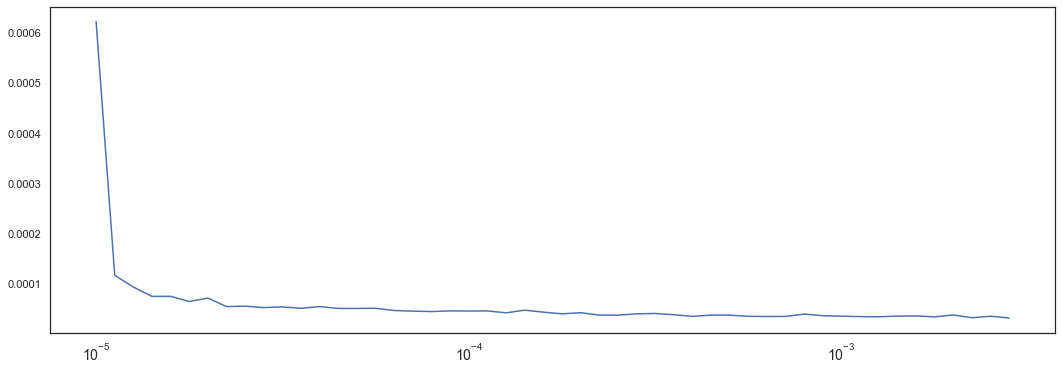

In [298]:
model_lstm = lstm_model(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, EPOCH, plotting=True)

In [299]:
y_hat_lstm = model_lstm.predict(X_val_lstm)
y_hat_train_lstm = model_lstm.predict(X_train_lstm)

In [300]:
mae_lstm = mean_absolute_error(y_hat_lstm, y_hat_lstm)

In [301]:
real_val, pred_val = inverse_transformation(X_val_lstm, y_val_lstm, y_hat_lstm)

In [302]:
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

In [303]:
real_val.tail()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
16,149.330002,150.839996,149.009995,149.102402,60893400.0,149.102402,55807000.0,0.982878,1.039448,0.480137,...,144.839996,455.959991,26.0,26.0,26.0,299.0,1.0,1.509995,0.310013,175.080002
17,149.360001,149.729996,148.490005,148.633087,56094900.0,149.102402,58494150.0,0.367688,0.784889,0.331856,...,146.550003,453.940002,27.0,27.0,27.0,300.0,2.0,0.369995,0.360001,174.559998
18,149.820007,153.169998,149.720001,152.347656,100077900.0,152.347656,78086400.0,0.869738,2.432449,2.626597,...,148.759995,458.320007,28.0,28.0,28.0,301.0,3.0,0.599991,0.100006,179.449997
19,147.220001,149.940002,146.410004,149.581696,124850400.0,152.347656,112464150.0,2.340522,2.283952,1.955830,...,149.259995,459.250000,29.0,29.0,29.0,302.0,4.0,0.139999,0.809998,175.740005
20,148.990005,149.699997,147.800003,148.742920,74588300.0,149.581696,99719350.0,0.982878,0.169710,0.593104,...,149.479996,460.040009,1.0,1.0,1.0,305.0,0.0,0.709991,1.160004,174.330002


Text(0.5, 1.0, 'MAE for this period: 7.67')

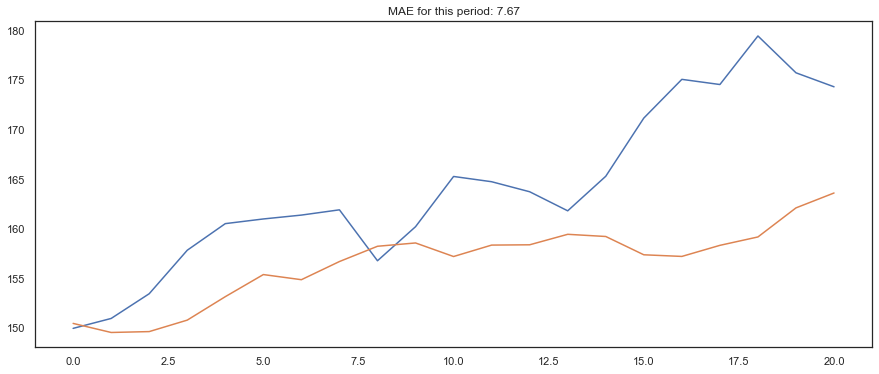

In [304]:
plt.figure(figsize=(15, 6))

plt.plot(real_val.iloc[:, 49])
plt.plot(pred_val.iloc[:, 49])

plt.title(f"MAE for this period: {round(mae_lstm, 2)}")

In [305]:
real_train, pred_train = inverse_transformation(X_train_lstm, y_train_lstm, y_hat_train_lstm)

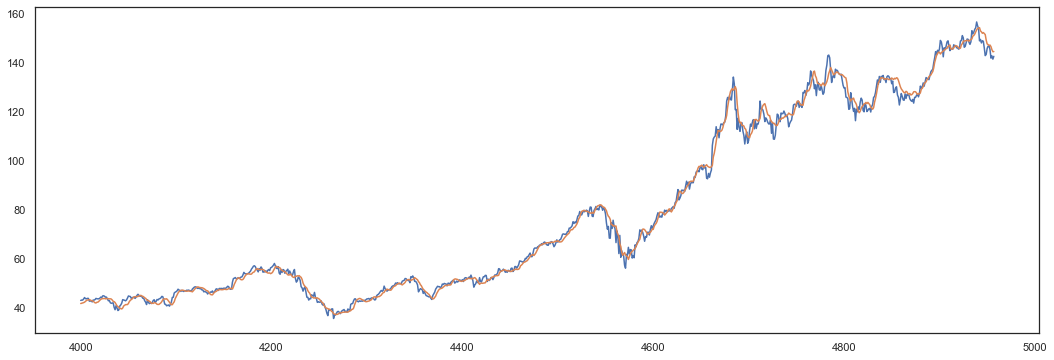

In [306]:
plt.figure(figsize=(18, 6))

plt.plot(real_train.iloc[4000:, 49])
plt.plot(pred_train.iloc[4000:, 49])

## Prediction

In [307]:
X_test_formula = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])

In [308]:
X_test_formula.shape

(30, 1, 49)

In [309]:
X_test_lstm = X_test_formula.reshape(1, X_test_formula.shape[0], X_test_formula.shape[2])

In [310]:
X_test_lstm.shape

(1, 30, 49)

In [311]:
y_hat_test_lstm = model_lstm.predict(X_test_lstm)

In [312]:
real_test, pred_test = inverse_transformation(X_test_lstm, y_test_lstm, y_hat_test_lstm)

In [313]:
y_val_lstm = np.array(real_val.iloc[-30:, 49])
y_test_lstm = np.array(real_test.iloc[:, 49])
pred_test = np.array(pred_test.iloc[-1:, 49])
mae_lstm = mean_absolute_error(real_val.iloc[:, 49], pred_val.iloc[:, 49])

For used windowed data: 30
Prediction scope for date 2022-01-28 00:00:00 / 1 days
The predicted price is 155.06$
With a spread of MAE is 7.67



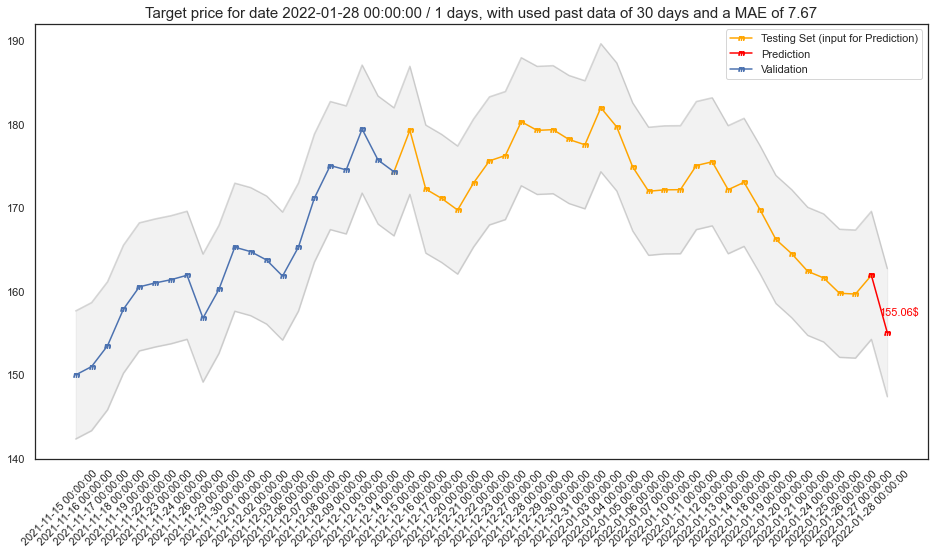


-----------------------------------------------------------------------------



In [331]:
plotting(y_val_lstm, y_test_lstm, pred_test, mae_lstm, WINDOW_LSTM, PREDICTION_SCOPE)

## Saving the Model

In [ ]:
#model.save('./SVM')

In [316]:
lstm_model = tf.keras.models.load_model("SVM")

# COMBINATION XGBoost-LSTM

In [315]:
mae_xgboost = mae

In [317]:
xgboost_model = joblib.load("XGBoost.pkl")

In [325]:
pred_test

array([155.06347891])

In [328]:
scope = predictions(mae_lstm, mae_xgboost, pred_test_xgb, pred_test)

In [329]:
avg_mae = (mae_lstm + mae_xgboost)/2

For used windowed data: 30
Prediction scope for date 2022-01-28 00:00:00 / 1 days
The predicted price is 151.99$
With a spread of MAE is 7.64



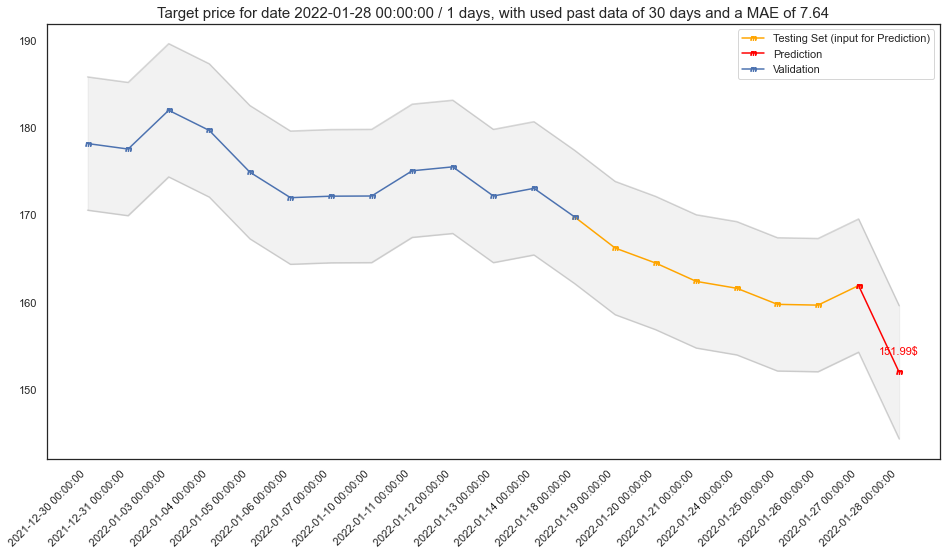


-----------------------------------------------------------------------------



In [330]:
plotting(y_val, y_test, scope, avg_mae, WINDOW, PREDICTION_SCOPE)